# Import libs

In [1]:
# sklearn libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso

# implemented structure
from src.handleData import handleData
from src.handleClassifier import handleClassifier
from src.handleResult import handleResult

# Load data

In [2]:
hD = handleData("./data/data.csv")  # construct handleData object
df = hD.loadData("id")  # load the data
labels = hD.encodeLabels(df, "species")  # get labels
dfTrain, dfTest = hD.splitData(df, 0.7, "species")  # get the training and testing sets

# No feature trimming

In [8]:
# The selected classifiers and their config
classifierList = [
    {
        "name": "LinearDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "QuadraticDiscriminantAnalysis",
        "preprocess": False,
        "fitStrategy": {
            "option": "CV",
            "config": {"n_jobs": -1, "scoring": "accuracy"},
        },
    },
    {
        "name": "LogisticRegression",
        "preprocess": True,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__C": [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
                },
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "SGDClassifier",
        "config": {"loss": "log_loss"},
        "preprocess": True,
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
                },
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "AdaBoostClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__learning_rate": [0.01, 0.1, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
    {
        "name": "BaggingClassifier",
        "preprocess": False,
        "config": {"base_estimator": DecisionTreeClassifier()},
        "fitStrategy": {
            "option": "GridSearch",
            "config": {
                "param_grid": {
                    "clf__base_estimator__max_depth": [1, 5, 10],
                    "clf__n_estimators": [50, 75, 100],
                    "clf__max_samples": [0.25, 0.5, 0.75, 1.0],
                    "clf__max_features": [0.25, 0.5, 0.75, 1.0],
                },
                "n_jobs": -1,
                "scoring": "accuracy",
            },
        },
    },
]

hC = handleClassifier()  # construct handleClassifier object
clf = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.9076738609112709
BaggingClassifier, GridSearchCV best score = 0.8686789698675842
LinearDiscriminantAnalysis, CV score = 0.9538421436763633
LogisticRegression, GridSearchCV best score = 0.9812428318214993
QuadraticDiscriminantAnalysis, CV score = 0.03322906891877802
SGDClassifier, GridSearchCV best score = 0.9408090918569492


# Feature reduction (PCA)

In [9]:
# change the config for a feature reduction
for classifierDict in classifierList:
    classifierDict["preprocess"] = True
    classifierDict["feature"] = {"option": "reduction"}
    classifierDict["fitStrategy"]["option"] = "GridSearch"

    if not "param_grid" in classifierDict["fitStrategy"]["config"]:
        classifierDict["fitStrategy"]["config"]["param_grid"] = dict()

    classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"] = [
        0.5,
        0.75,
        0.85,
    ]

clfReduction = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.919195078719633
BaggingClassifier, GridSearchCV best score = 0.9336565530184548
LinearDiscriminantAnalysis, GridSearchCV best score = 0.9682619122093629
LogisticRegression, GridSearchCV best score = 0.9841413825461369
QuadraticDiscriminantAnalysis, GridSearchCV best score = 0.09676780314878532
SGDClassifier, GridSearchCV best score = 0.9423104994265458


# Feature selection (Lasso)

In [10]:
# change the config for a feature selection
for classifierDict in classifierList:
    classifierDict["feature"]["option"] = "selection"
    classifierDict["feature"]["config"] = {"estimator": Lasso()}
    del classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__n_components"]
    classifierDict["fitStrategy"]["config"]["param_grid"]["ftr__estimator__alpha"] = [
        1.0,
        2.5,
        5.0,
    ]

clfSelection = hC.fitClassifiers(dfTrain, classifierList)  # fit

AdaBoostClassifier, GridSearchCV best score = 0.8757898029402564
BaggingClassifier, GridSearchCV best score = 0.9091231362735899
LinearDiscriminantAnalysis, GridSearchCV best score = 0.9264310290897717
LogisticRegression, GridSearchCV best score = 0.9307475758523616
QuadraticDiscriminantAnalysis, GridSearchCV best score = 0.03469919716400792
SGDClassifier, GridSearchCV best score = 0.8845584402043583


# Prediction results
## No feature trimming

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.946128,0.958081,0.946128,0.944228,0.999210
BaggingClassifier,0.905724,0.893266,0.905724,0.888865,0.999084
LinearDiscriminantAnalysis,0.973064,0.979966,0.973064,0.972751,0.999989
LogisticRegression,0.979798,0.984848,0.979798,0.979221,1.000000
QuadraticDiscriminantAnalysis,0.043771,0.073148,0.043771,0.049897,0.517007
SGDClassifier,0.956229,0.969697,0.956229,0.954930,0.999782


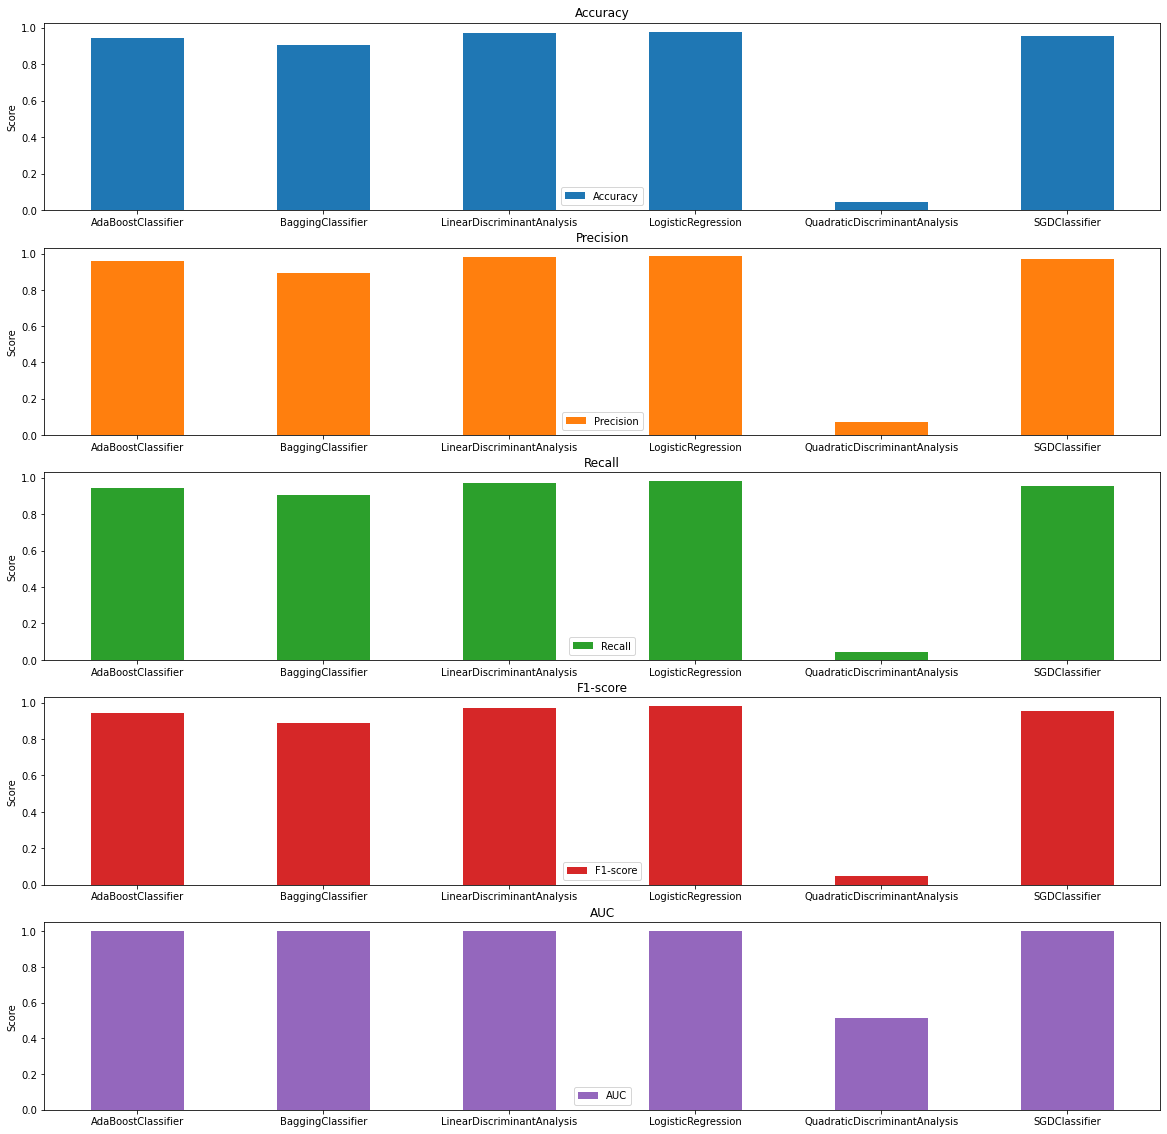

In [11]:
hR = handleResult()
hR.predictionResult(dfTest, clf)
hR.plotBarChart()

## Feature reduction (PCA)

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.946128,0.953824,0.946128,0.940260,0.999301
BaggingClassifier,0.962963,0.971380,0.962963,0.962001,0.999668
LinearDiscriminantAnalysis,0.973064,0.979125,0.973064,0.971837,0.999954
LogisticRegression,0.986532,0.989899,0.986532,0.986147,1.000000
QuadraticDiscriminantAnalysis,0.632997,0.641456,0.632997,0.599197,0.983726
SGDClassifier,0.962963,0.975709,0.962963,0.963733,0.999834


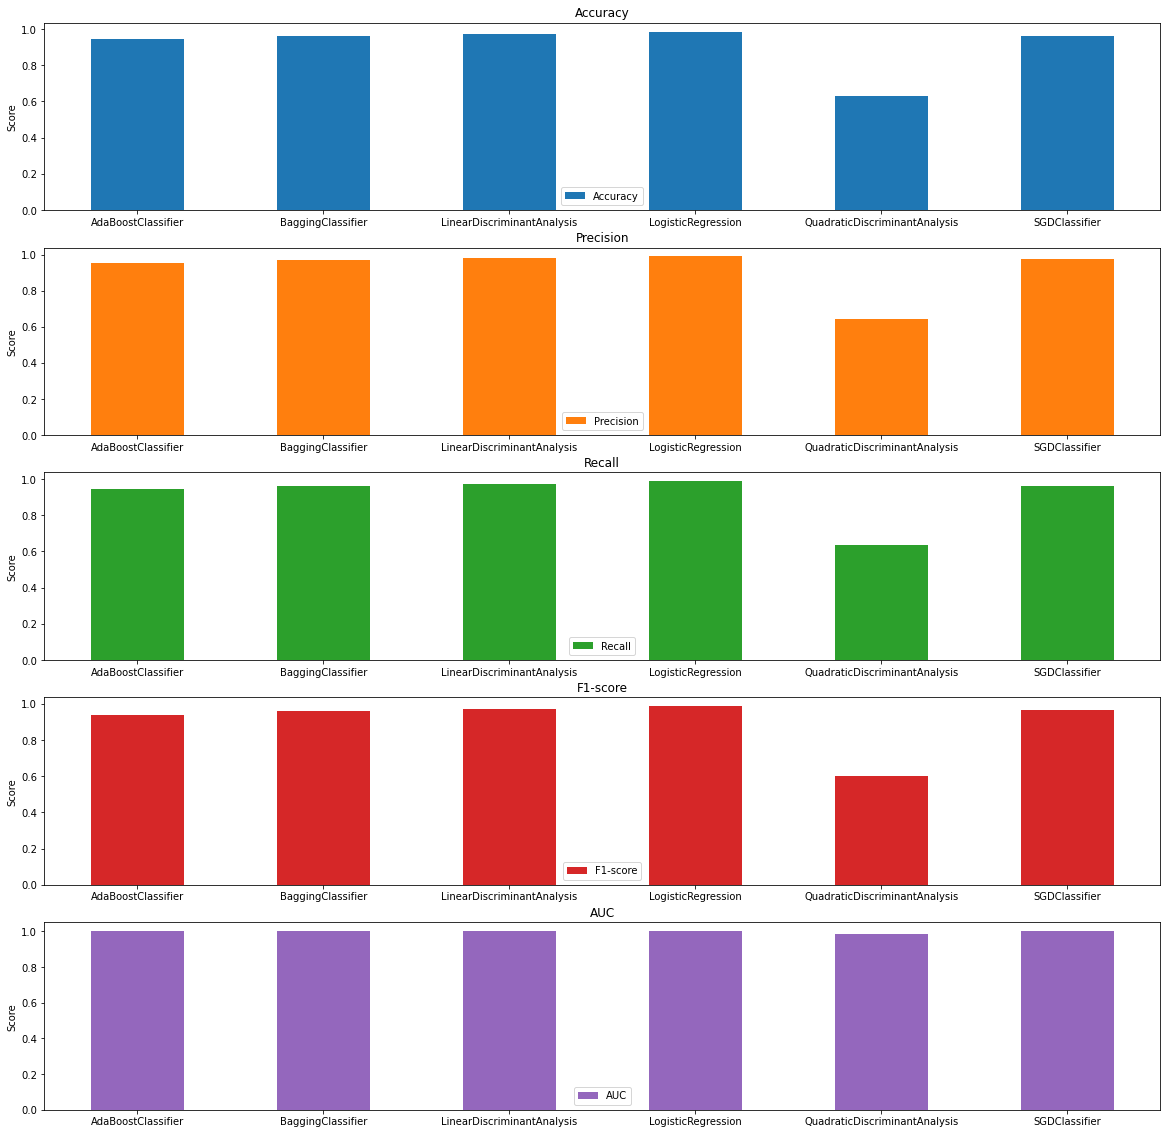

In [12]:
hR.predictionResult(dfTest, clfReduction)
hR.plotBarChart()

## Feature selection (Lasso)

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoostClassifier,0.872054,0.888083,0.872054,0.862604,0.996060
BaggingClassifier,0.895623,0.902020,0.895623,0.883045,0.998660
LinearDiscriminantAnalysis,0.885522,0.905387,0.885522,0.878283,0.996862
LogisticRegression,0.912458,0.932323,0.912458,0.906638,0.998408
QuadraticDiscriminantAnalysis,0.037037,0.026684,0.037037,0.030256,0.513605
SGDClassifier,0.861953,0.904329,0.861953,0.860491,0.997377


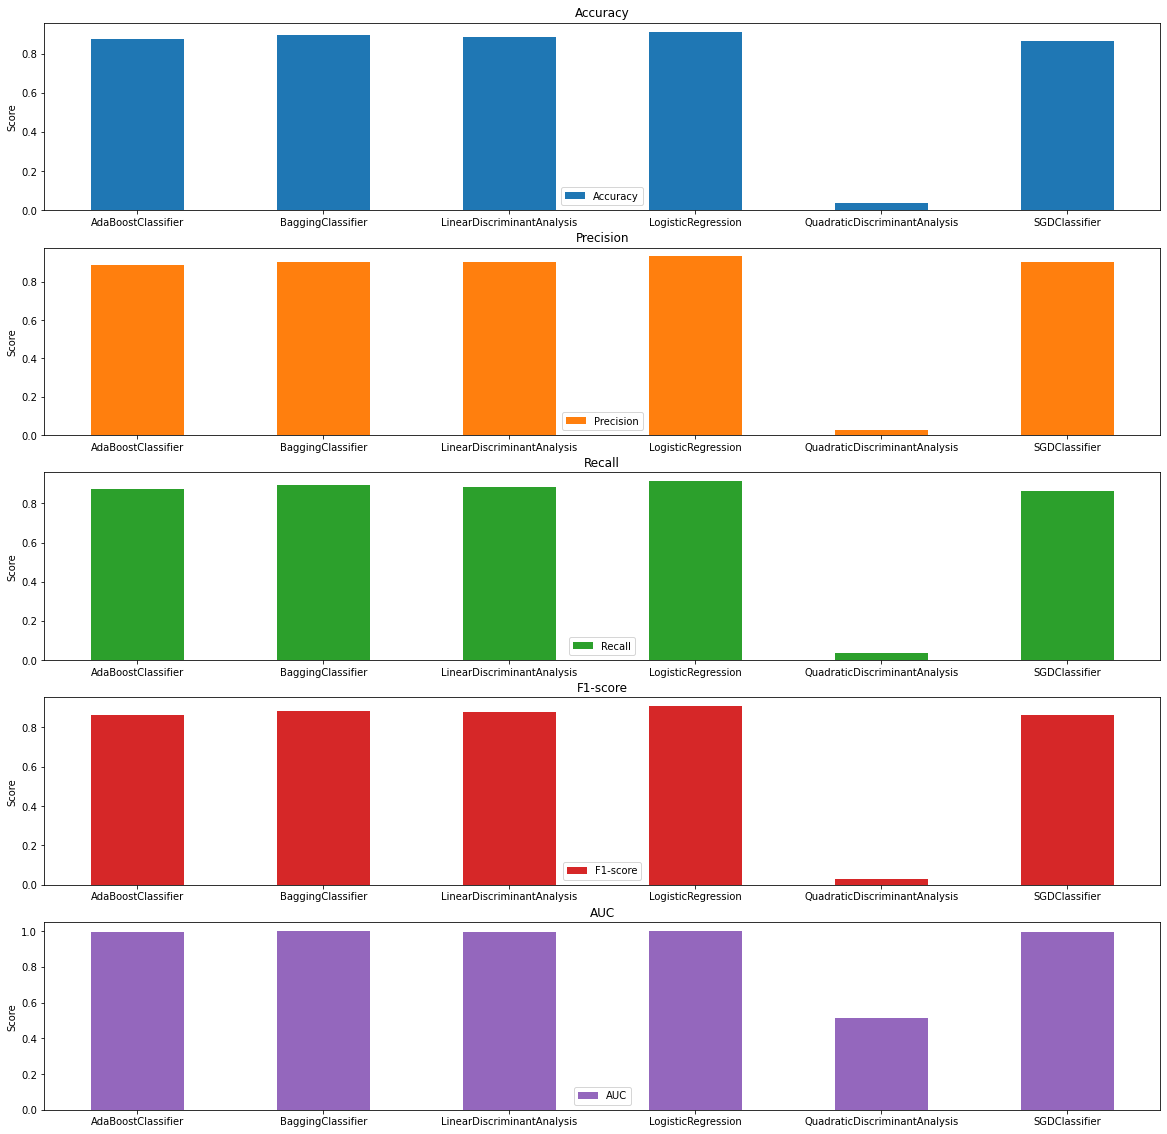

In [13]:
hR.predictionResult(dfTest, clfSelection)
hR.plotBarChart()